# Centralized policy trained with SAC

In this notebook, we train a centralized policy that take as input the observation of both agents and outputs both actions. The rewards of the two agents is summed together.
In our case, it is enough to provide as observations the relative position of the pad and agent speed.

You can skip training and instead load the last trained policy by changing the flag below.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

In [3]:
from navground import core, sim
from navground.learning import ControlActionConfig, DefaultObservationConfig
from stable_baselines3.common.monitor import Monitor
from navground.learning.parallel_env import JointEnv
from navground.learning.examples.pad import get_env, marker

name = "Centralized"

action = ControlActionConfig(use_acceleration_action=True, max_acceleration=1, fix_orientation=True)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)
sensors = [marker()]
train_env = get_env(action=action, observation=observation, 
                    sensors=sensors, start_in_opposite_sides=False)
train_venv = JointEnv(train_env)
test_env = get_env(action=action, observation=observation, 
                   sensors=sensors, start_in_opposite_sides=True)
test_venv = Monitor(JointEnv(test_env))

Observations from the two agents are stacked together (the first axis indicizes the agents).

In [4]:
train_venv.observation_space

Dict('ego_velocity': Box(-0.14, 0.14, (2, 1), float32), 'pad/x': Box(-1.0, 1.0, (2, 1), float32))

like their actions (linear accelerations)

In [5]:
train_venv.action_space

Box(-1.0, 1.0, (2, 1), float32)

In [6]:
%%skip_if $training

import pathlib, os
from stable_baselines3 import SAC

log = max(pathlib.Path(f'logs/{name}/SAC').glob('*'), key=os.path.getmtime)

In [7]:
%%run_if $training

from stable_baselines3 import SAC
from datetime import datetime as dt
from stable_baselines3.common.logger import configure
from navground.learning.utils.sb3 import callbacks
from navground.learning.scenarios.pad import render_kwargs

model = SAC("MultiInputPolicy", train_venv, verbose=0)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log = f"logs/{name}/SAC/{stamp}"
model.set_logger(configure(log, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_venv, best_model_save_path=log, 
                eval_freq=1000, export_to_onnx=True, grouped=True, **render_kwargs())
log

'logs/Centralized/SAC/20250521_100129'

In [8]:
%%run_if $training

model.learn(total_timesteps=50_000, reset_num_timesteps=False, log_interval=10, callback=cbs)
model.num_timesteps

  0%|          | 0/50000 [00:00<?, ?it/s]

50000

In [9]:
from stable_baselines3.common.evaluation import evaluate_policy

best_model = SAC.load(f'{log}/best_model')
evaluate_policy(best_model.policy, test_venv, n_eval_episodes=100)

(-55.15963947, 19.354489778550846)

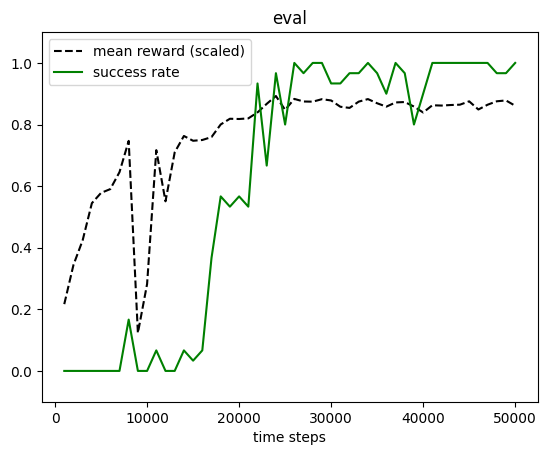

In [10]:
from navground.learning.utils.sb3 import plot_eval_logs

plot_eval_logs(log, reward_low=-400, reward_high=0, success=True)

In [11]:
from navground.learning.evaluation.video import display_episode_video

display_episode_video(test_env, policy=best_model.policy, factor=4, seed=1, 
                      grouped=True, **render_kwargs())

In [14]:
from navground.learning.evaluation.video import record_episode_video

record_episode_video(test_env, policy=best_model.policy, path=f'../videos/{name}.mp4', seed=1, 
                     grouped=True, **render_kwargs())

## Policy

Let us have a look at the trained policy.

In [15]:
import numpy as np

xs = np.linspace(-1, 1, 101, dtype=np.float32)
ys = np.linspace(-1, 1, 101, dtype=np.float32)
xv, yv = np.meshgrid(xs, ys)
obs = {'pad/x': np.stack([xv, yv], axis=-1).reshape(-1, 2, 1), 
       'ego_velocity': np.full((101, 101, 2, 1), 0.07, dtype=np.float32)}
act, _ = model.policy.predict(obs, deterministic=True)
act = act.reshape(101, 101, 2)

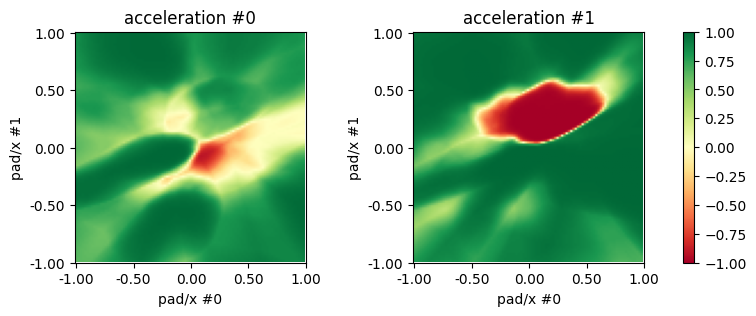

In [16]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
for i, ax in enumerate(axs):
    im = ax.imshow(act[::-1, :, i], vmin=-1, vmax=1, cmap='RdYlGn')
    ax.set_xlabel('pad/x #0')
    ax.set_ylabel('pad/x #1')
    lxs = [f'{x:.2f}' for x in np.linspace(xs[0], xs[-1], 5)]
    lys = [f'{y:.2f}' for y in np.linspace(ys[0], ys[-1], 5)][::-1]
    ax.set_xticks(np.linspace(0, 101, 5), lxs)
    ax.set_yticks(np.linspace(0, 101, 5), lys)
    ax.title.set_text(f'acceleration #{i}')
fig.colorbar(im, ax=axs.ravel().tolist())
# fig.suptitle('Central policy');

We see that the central policy tends to favor one of the two agents, make the other brake even if it would be nearer to the pad.